In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn import metrics
import lightgbm as lgb
from copy import deepcopy
# import graphviz
import os
from sklearn import preprocessing
%matplotlib inline
plt.rcParams['figure.figsize']=12,4

In [74]:
current_dir = r'D:\yuwei\study\competition\Predict-demand-online-classified-ad'
data_dirs = dict()
data_dirs['train_data'] = os.path.join(current_dir, 'data/train.csv')
data_dirs['test_data'] = os.path.join(current_dir, 'data/test.csv')
data_dirs['pred_result'] = os.path.join(current_dir, 'data/20180501_02LightGBM.csv')
data_dirs['model_path'] = os.path.join(current_dir, 'data/model_data/20180501_02LightGBM.pkl')

In [3]:
def prepare_data(data_dirs):
    train_df = pd.read_csv(data_dirs['train_data'], parse_dates=["activation_date"])
    test_df = pd.read_csv(data_dirs['test_data'], parse_dates=["activation_date"])
    
    use_features = set()

    train_y = train_df["deal_probability"].values
    test_id = test_df["item_id"].values
    # explore features
    # weekday
    train_df["activation_weekday"] = train_df["activation_date"].dt.weekday
    test_df["activation_weekday"] = test_df["activation_date"].dt.weekday
    # hour
    train_df['activation_hour'] = train_df["activation_date"].dt.hour
    test_df['activation_hour'] = test_df["activation_date"].dt.hour
    
    use_features.update(['activation_weekday','activation_hour'])
    
    # Label encode the categorical variables #
    cat_vars = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1", "param_2", "param_3"]
    for col in cat_vars:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
        train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
        test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))
    
    use_features.update(cat_vars)
    
    # title length
    train_df['title_len'] = train_df['title'].apply(len)
    test_df['title_len'] = test_df['title'].apply(len)
    # description length
    train_df['descrip_len'] = train_df['description'].apply(lambda x: 0 if x is np.nan else len(x))
    test_df['descrip_len'] = test_df['description'].apply(lambda x: 0 if x is np.nan else len(x))
    
    use_features.update(['title_len', 'descrip_len'])
    use_features.update(['price', 'item_seq_number', 'image_top_1'])
    use_features=list(use_features)
    train_X = train_df[use_features]
    test_X = test_df[use_features]
    return train_X, train_y, test_X, test_id, cat_vars+['activation_weekday','activation_hour']

In [4]:
train_X, train_y, test_X, test_id, cat_vars= prepare_data(data_dirs)

In [5]:
X_train,X_val,y_train,y_val=train_test_split(train_X,train_y,test_size=0.20,random_state=9)

# 1 Base line

In [45]:
def modelfit(alg,X,y,X_test,y_test,cat_features,cvparams,folds=None,useTrainCV=True,cv_folds=5,early_stopping_rounds=30):
    feature_names=list(X.columns)
    if useTrainCV==True:
        dtrain=lgb.Dataset(X, label=y, reference=None, 
                           weight=None, group=None, silent=False, feature_name=feature_names,
                            categorical_feature=cat_features,params=None, free_raw_data=True)
        cvresult=lgb.cv(cvparams,dtrain,num_boost_round=5000,folds=folds,nfold=cv_folds,stratified=False,
                        metrics='rmse',feature_name=feature_names,categorical_feature=cat_features,early_stopping_rounds=early_stopping_rounds,
                        verbose_eval=20,show_stdv =True,seed=9)
        #,feval=gini_normalized
        alg.set_params(n_estimators=len(cvresult['rmse-mean']))
        print('Best Iteration:',len(cvresult['rmse-mean']))
        
    alg.fit(X,y,eval_metric='rmse',feature_name=feature_names,categorical_feature=cat_features,
            eval_set=[(X,y),(X_test, y_test)],eval_names=['train','val'],verbose=20)
    
    #Predict training set:
    dtrain_predictions=alg.predict(X)
    
    #pPredict test set:
    dtest_predictions=alg.predict(X_test)
    
    #Print Mode report:
    print('Model report on trian:')
    print('Train RMSE:{0:.4f}'.format(np.sqrt(metrics.mean_squared_error(y,dtrain_predictions))))
    print('Model report on test:')
    print('Test RMSE:{0:.4f}'.format(np.sqrt(metrics.mean_squared_error(y_test,dtest_predictions))))
    
    feat_imp=pd.Series(alg.feature_importances_,index=X.columns).sort_values(ascending=True)
    #plt.figure()
    #feat_imp.plot(kind='barh',title='Feature Importances',color='green')
    #plt.ylabel('Feature Importance Score')
    lgb.plot_importance(alg,importance_type='gain')
    lgb.plot_metric(lgbr)
    return feat_imp

def turnParams(model,X,y,cat_features,searchParam,modelparams,scoring='rmse',cv=5):
    gsc=GridSearchCV(estimator=model.__class__(**modelparams),param_grid=searchParam,scoring=scoring,
                    iid=False,cv=cv)
    gsc.fit(X,y,eval_metric='rmse',categorical_feature=cat_features)
    param_name=list(searchParam.keys())[0]
    columns=[p[param_name] for p in gsc.cv_results_['params']]
    cv_scores=pd.DataFrame([gsc.cv_results_['mean_test_score'],
                            gsc.cv_results_['mean_train_score'],
                            gsc.cv_results_['std_test_score'],
                            gsc.cv_results_['std_train_score']],
                            index=['mean_test_score','mean_train_score','std_test_score','std_train_score'],
                            columns=columns).T
    #cv_scores.index.name=param_name
    for param in gsc.best_params_.keys():
        modelparams[param]=gsc.best_params_[param]
    print('Best params:')
    for param in gsc.best_params_.keys():
        print(param,':',gsc.best_params_[param])
    print('Best score:',gsc.best_score_)
    print(cv_scores)

In [46]:
params={'boosting_type': 'gbdt',
        'colsample_bytree': 0.8,
       'learning_rate': 0.1,
       'max_bin': 168,
       'max_depth': 9,
       'min_child_samples': 30,
       'min_child_weight': 5,
       'min_split_gain': 1,
       'n_estimators': 200,
       'n_jobs': -1,
       'num_leaves': 60,
       'objective': 'regression',
       'random_state': 9,
       'reg_alpha': 0,
       'reg_lambda': 0,
       'subsample': 0.9,
       'subsample_freq': 1
       }

cvparams={'boosting_type':'gbdt',
        'num_leaves':60,
        'max_depth':9,
        'learning_rate':0.1,
        'max_bin':168,
        'objective':'regression',
        'min_gain_to_split':1,
        'min_sum_hessian_in_leaf':5,
        'min_data_in_leaf':1,
        'bagging_fraction':0.9,
        'bagging_freq':1,
        'feature_fraction':0.8,
        'lambda_l1':0,
        'lambda_l2':0,
        'num_threads':-1,
       }
#在sklaearn接口中，参数名称发生了变化，需要进行映射
tran_table={ 'min_split_gain':'min_gain_to_split',
             'min_child_weight':'min_sum_hessian_in_leaf',
             'min_child_samples':'min_data_in_leaf',
             'subsample':'bagging_fraction',
             'subsample_freq':'bagging_freq',
             'colsample_bytree':'feature_fraction',
             'reg_alpha':'lambda_l1',
             'reg_lambda':'lambda_l2',
             'n_jobs':'num_threads',
            
             'boosting_type':'boosting_type',
             'num_leaves':'num_leaves',
             'max_depth':'max_depth',
             'learning_rate':'learning_rate',
             'max_bin':'max_bin',
             'objective':'objective'}
def get_lgb_params(sklearn_params,cvparams,tran_table):
    for sklearn_param,lgb_param in tran_table.items():
        cvparams[lgb_param]=sklearn_params[sklearn_param]

In [47]:
lgbr=lgb.LGBMRegressor(**params)

[20]	cv_agg's rmse: 0.23134 + 0.000208812
[40]	cv_agg's rmse: 0.229001 + 0.000283628
[60]	cv_agg's rmse: 0.228247 + 0.000268589
[80]	cv_agg's rmse: 0.228041 + 0.000241264
[100]	cv_agg's rmse: 0.228034 + 0.000237637
[120]	cv_agg's rmse: 0.228034 + 0.000237637
Best Iteration: 91


C:\Anaconda3\lib\site-packages\lightgbm\basic.py:1038: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['activation_hour', 'activation_weekday', 'category_name', 'city', 'param_1', 'param_2', 'param_3', 'parent_category_name', 'region', 'user_type']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[20]	train's rmse: 0.230708	val's rmse: 0.231729
[40]	train's rmse: 0.227292	val's rmse: 0.229091
[60]	train's rmse: 0.225842	val's rmse: 0.228202
[80]	train's rmse: 0.225213	val's rmse: 0.22788
Model report on trian:
Train RMSE:0.2252
Model report on test:
Test RMSE:0.2279


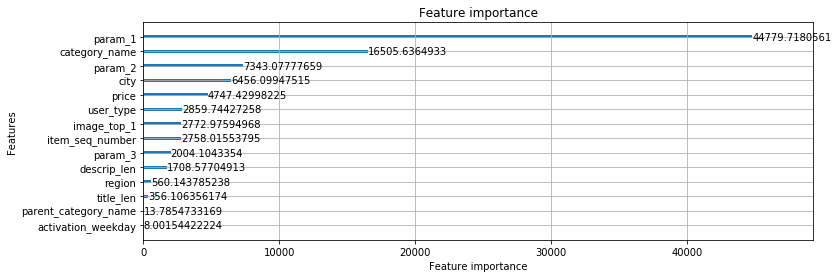

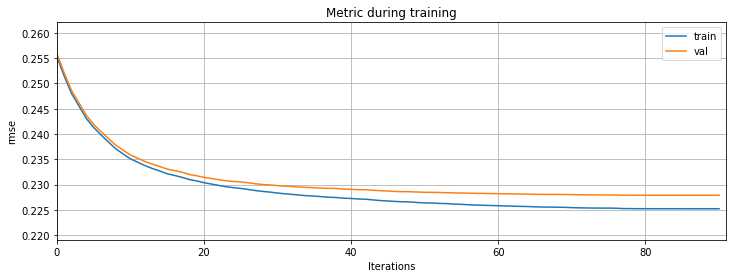

In [48]:
get_lgb_params(lgbr.get_params(),cvparams,tran_table)

feat_imp=modelfit(lgbr,X_train,y_train,X_val,y_val,cat_vars,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

In [49]:
params['n_estimators']=91

# 2 Tune params

In [50]:
#不重要的警告信息不予显示
import warnings
warnings.filterwarnings("ignore")

In [51]:
def rmse(y_true, y_pred, sample_weight=None, multioutput='uniform_average'):
    return np.sqrt(metrics.mean_squared_error(y_true,y_pred))
scorer = metrics.make_scorer(rmse, greater_is_better=False)

## 2.1 num_leaves

In [52]:
searchParam={'num_leaves':(20,25,30,35,40,50)}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
num_leaves : 50
Best score: -0.228091815583
    mean_test_score  mean_train_score  std_test_score  std_train_score
20        -0.228925         -0.227568        0.000823         0.000170
25        -0.228616         -0.226926        0.000832         0.000146
30        -0.228434         -0.226512        0.000789         0.000187
35        -0.228342         -0.226275        0.000772         0.000204
40        -0.228256         -0.226027        0.000800         0.000186
50        -0.228092         -0.225486        0.000817         0.000161


In [53]:
searchParam={'num_leaves':(45,49,50,51,55,60)}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
num_leaves : 60
Best score: -0.227926272887
    mean_test_score  mean_train_score  std_test_score  std_train_score
45        -0.228149         -0.225709        0.000794         0.000195
49        -0.228067         -0.225536        0.000761         0.000222
50        -0.228092         -0.225486        0.000817         0.000161
51        -0.228078         -0.225501        0.000779         0.000174
55        -0.227986         -0.225300        0.000762         0.000196
60        -0.227926         -0.225124        0.000779         0.000218


In [54]:
searchParam={'num_leaves':(60,70,80,90)}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
num_leaves : 90
Best score: -0.22776057427
    mean_test_score  mean_train_score  std_test_score  std_train_score
60        -0.227926         -0.225124        0.000779         0.000218
70        -0.227820         -0.224832        0.000796         0.000212
80        -0.227794         -0.224681        0.000786         0.000171
90        -0.227761         -0.224519        0.000749         0.000229


In [55]:
searchParam={'num_leaves':(85,90,100,110)}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
num_leaves : 100
Best score: -0.227648810081
     mean_test_score  mean_train_score  std_test_score  std_train_score
85         -0.227770         -0.224588        0.000747         0.000198
90         -0.227761         -0.224519        0.000749         0.000229
100        -0.227649         -0.224323        0.000785         0.000187
110        -0.227682         -0.224221        0.000780         0.000209


In [56]:
searchParam={'num_leaves':(95,100,105)}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
num_leaves : 100
Best score: -0.227648810081
     mean_test_score  mean_train_score  std_test_score  std_train_score
95         -0.227738         -0.224448        0.000764         0.000191
100        -0.227649         -0.224323        0.000785         0.000187
105        -0.227658         -0.224262        0.000751         0.000246


## 2.2 max_depth

In [57]:
searchParam={'max_depth':[2,6,10,15,20]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
max_depth : 20
Best score: -0.227395507968
    mean_test_score  mean_train_score  std_test_score  std_train_score
2         -0.233572         -0.233397        0.000872         0.000207
6         -0.228607         -0.226615        0.000772         0.000213
10        -0.227634         -0.224135        0.000798         0.000220
15        -0.227436         -0.223506        0.000789         0.000204
20        -0.227396         -0.223415        0.000780         0.000213


In [58]:
searchParam={'max_depth':[19,20,21,25]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
max_depth : 25
Best score: -0.227383361779
    mean_test_score  mean_train_score  std_test_score  std_train_score
19        -0.227449         -0.223422        0.000812         0.000189
20        -0.227396         -0.223415        0.000780         0.000213
21        -0.227395         -0.223410        0.000804         0.000138
25        -0.227383         -0.223416        0.000790         0.000180


In [60]:
searchParam={'max_depth':[28,29,30,31,32]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
max_depth : 29
Best score: -0.2273731211
    mean_test_score  mean_train_score  std_test_score  std_train_score
28        -0.227375         -0.223385        0.000801         0.000162
29        -0.227373         -0.223395        0.000801         0.000143
30        -0.227373         -0.223387        0.000801         0.000159
31        -0.227373         -0.223387        0.000801         0.000159
32        -0.227373         -0.223387        0.000801         0.000159


## 2.3 subsample

In [61]:
searchParam={'subsample':[0.5,0.7,0.9,1.0]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
subsample : 0.9
Best score: -0.2273731211
     mean_test_score  mean_train_score  std_test_score  std_train_score
0.5        -0.227937         -0.224534        0.000831         0.000175
0.7        -0.227560         -0.223717        0.000751         0.000205
0.9        -0.227373         -0.223395        0.000801         0.000143
1.0        -0.227421         -0.223421        0.000809         0.000157


In [62]:
searchParam={'subsample':[0.88,0.89,0.9,0.91,0.92]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
subsample : 0.9
Best score: -0.2273731211
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.88        -0.227398         -0.223381        0.000790         0.000159
0.89        -0.227426         -0.223455        0.000802         0.000154
0.90        -0.227373         -0.223395        0.000801         0.000143
0.91        -0.227426         -0.223457        0.000726         0.000278
0.92        -0.227401         -0.223402        0.000799         0.000217


## 2.4 subsample_freq

In [28]:
searchParam={'subsample_freq':[1,2,3,4,5,6,7,8,9]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
subsample_freq : 1
Best score: -0.229257495593
   mean_test_score  mean_train_score  std_test_score  std_train_score
1        -0.229257         -0.226336        0.000786         0.000323
2        -0.229425         -0.226583        0.000827         0.000241
3        -0.229316         -0.226504        0.000841         0.000294
4        -0.229406         -0.226717        0.000800         0.000331
5        -0.229599         -0.226965        0.000864         0.000261
6        -0.229510         -0.226922        0.000888         0.000080
7        -0.229540         -0.226987        0.000884         0.000145
8        -0.229432         -0.226944        0.000908         0.000349
9        -0.229517         -0.226970        0.000827         0.000207


## 2.5 colsample_bytree

In [63]:
searchParam={'colsample_bytree':[0.5,0.7,0.8,0.9,1.0]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
colsample_bytree : 0.8
Best score: -0.2273731211
     mean_test_score  mean_train_score  std_test_score  std_train_score
0.5        -0.227520         -0.224265        0.000805         0.000194
0.7        -0.227460         -0.223886        0.000823         0.000146
0.8        -0.227373         -0.223395        0.000801         0.000143
0.9        -0.227514         -0.223336        0.000768         0.000220
1.0        -0.227482         -0.223019        0.000774         0.000201


## 2.6 reg_alpha

In [64]:
searchParam={'reg_alpha':[0,1e-5,1e-3,0.1,0.5,1,3,5,10]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
reg_alpha : 0
Best score: -0.2273731211
          mean_test_score  mean_train_score  std_test_score  std_train_score
0.00000         -0.227373         -0.223395        0.000801         0.000143
0.00001         -0.227373         -0.223395        0.000801         0.000143
0.00100         -0.227390         -0.223459        0.000806         0.000190
0.10000         -0.227385         -0.223356        0.000760         0.000240
0.50000         -0.227454         -0.223480        0.000778         0.000217
1.00000         -0.227444         -0.223547        0.000820         0.000198
3.00000         -0.227461         -0.223632        0.000764         0.000221
5.00000         -0.227535         -0.223794        0.000746         0.000232
10.00000        -0.227610         -0.224185        0.000770         0.000192


## 2.7 reg_lambda

In [65]:
searchParam={'reg_lambda':[0,1e-5,1e-3,0.1,0.5,1,3,5,10]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
reg_lambda : 0
Best score: -0.2273731211
          mean_test_score  mean_train_score  std_test_score  std_train_score
0.00000         -0.227373         -0.223395        0.000801         0.000143
0.00001         -0.227373         -0.223395        0.000801         0.000143
0.00100         -0.227383         -0.223417        0.000801         0.000149
0.10000         -0.227408         -0.223365        0.000751         0.000238
0.50000         -0.227431         -0.223433        0.000759         0.000205
1.00000         -0.227435         -0.223432        0.000797         0.000174
3.00000         -0.227458         -0.223500        0.000799         0.000148
5.00000         -0.227430         -0.223459        0.000817         0.000111
10.00000        -0.227451         -0.223465        0.000769         0.000157


In [66]:
params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_bin': 168,
 'max_depth': 29,
 'min_child_samples': 30,
 'min_child_weight': 5,
 'min_split_gain': 1,
 'n_estimators': 91,
 'n_jobs': -1,
 'num_leaves': 100,
 'objective': 'regression',
 'random_state': 9,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'subsample': 0.9,
 'subsample_freq': 1}

## 2.8 min_child_samples

In [67]:
searchParam={'min_child_samples':[1,2,5,10,20,30,50,100,150,200,300,400,500]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_child_samples : 30
Best score: -0.2273731211
     mean_test_score  mean_train_score  std_test_score  std_train_score
1          -0.227463         -0.223768        0.000739         0.000191
2          -0.227463         -0.223768        0.000739         0.000191
5          -0.227410         -0.223452        0.000802         0.000191
10         -0.227402         -0.223451        0.000812         0.000191
20         -0.227399         -0.223454        0.000809         0.000184
30         -0.227373         -0.223395        0.000801         0.000143
50         -0.227408         -0.223466        0.000786         0.000239
100        -0.227420         -0.223444        0.000794         0.000176
150        -0.227437         -0.223432        0.000775         0.000199
200        -0.227450         -0.223436        0.000764         0.000196
300        -0.227439         -0.223449        0.000752         0.000160
400        -0.227454         -0.223477        0.000734         0.000232
50

In [172]:
searchParam={'min_child_samples':[3,4,5,6,7]}
turnParams(lgbr,X_train,y_train,cat_vars,searchParam,params,scoring=scorer,cv=5);

Best params:
min_child_samples : 3
Best score: 0.63428579984
   mean_test_score  mean_train_score  std_test_score  std_train_score
3         0.634286          0.676859        0.002134         0.001064
4         0.634286          0.676859        0.002134         0.001064
5         0.634286          0.676859        0.002134         0.001064
6         0.634286          0.676859        0.002134         0.001064
7         0.634286          0.676859        0.002134         0.001064


## 2.9 min_child_weight

In [173]:
searchParam={'min_child_weight':[1e-5,1e-3,0.1,0.5,1.0,3.0,5.0]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_child_weight : 1e-05
Best score: 0.63428579984
         mean_test_score  mean_train_score  std_test_score  std_train_score
0.00001         0.634286          0.676859        0.002134         0.001064
0.00100         0.634286          0.676859        0.002134         0.001064
0.10000         0.634286          0.676859        0.002134         0.001064
0.50000         0.634286          0.676859        0.002134         0.001064
1.00000         0.634286          0.676859        0.002134         0.001064
3.00000         0.634286          0.676859        0.002134         0.001064
5.00000         0.634286          0.676859        0.002134         0.001064


## 2.10 max_bin

In [174]:
searchParam={'max_bin':[31,63,127,255,511]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
max_bin : 255
Best score: 0.63428579984
     mean_test_score  mean_train_score  std_test_score  std_train_score
31          0.632909          0.675524        0.002234         0.001220
63          0.633120          0.675998        0.001408         0.000908
127         0.633413          0.676443        0.002107         0.001359
255         0.634286          0.676859        0.002134         0.001064
511         0.632746          0.676565        0.001914         0.001183


## 2.11 min_split_gain

In [183]:
searchParam={'min_split_gain':[0.5,0.9,1,1.1,2,3]}
turnParams(lgbc,X,y,cat_features,searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_split_gain : 1
Best score: 0.63428579984
     mean_test_score  mean_train_score  std_test_score  std_train_score
0.5         0.634007          0.676327        0.002064         0.000875
0.9         0.634016          0.676880        0.002242         0.001080
1.0         0.634286          0.676859        0.002134         0.001064
1.1         0.633735          0.676845        0.002634         0.001043
2.0         0.634004          0.676904        0.001815         0.001361
3.0         0.633310          0.676621        0.001720         0.001495


## 2.12 lower learning_rate

[20]	cv_agg's rmse: 0.235345 + 0.000204966
[40]	cv_agg's rmse: 0.230121 + 0.000225825
[60]	cv_agg's rmse: 0.228531 + 0.00026614
[80]	cv_agg's rmse: 0.227803 + 0.000287695
[100]	cv_agg's rmse: 0.227426 + 0.000285643
[120]	cv_agg's rmse: 0.227291 + 0.000287548
[140]	cv_agg's rmse: 0.227277 + 0.000281527
[160]	cv_agg's rmse: 0.227277 + 0.000281527
Best Iteration: 135
[20]	train's rmse: 0.234909	val's rmse: 0.235896
[40]	train's rmse: 0.228899	val's rmse: 0.230482
[60]	train's rmse: 0.226531	val's rmse: 0.228688
[80]	train's rmse: 0.225101	val's rmse: 0.227826
[100]	train's rmse: 0.224103	val's rmse: 0.227382
[120]	train's rmse: 0.223621	val's rmse: 0.227203
Model report on trian:
Train RMSE:0.2235
Model report on test:
Test RMSE:0.2272


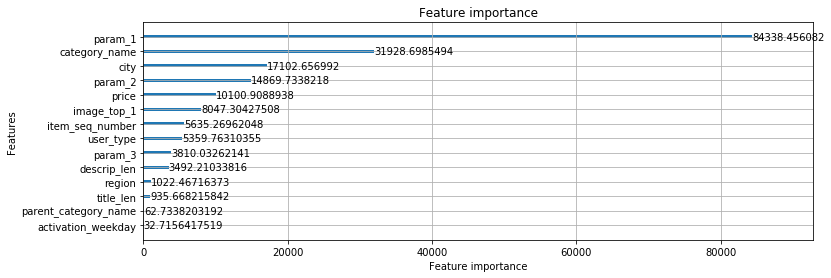

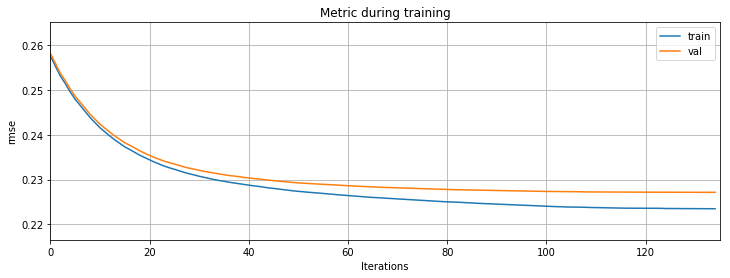

In [68]:
params['learning_rate']=0.05
lgbr=lgb.LGBMRegressor(**params)
get_lgb_params(params,cvparams,tran_table)
feat_imp=modelfit(lgbr,X_train,y_train,X_val,y_val,cat_vars,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

[20]	cv_agg's rmse: 0.236703 + 0.00139293
[40]	cv_agg's rmse: 0.231819 + 0.00130524
[60]	cv_agg's rmse: 0.230283 + 0.00127033
[80]	cv_agg's rmse: 0.229483 + 0.00124622
[100]	cv_agg's rmse: 0.22899 + 0.00123823
[120]	cv_agg's rmse: 0.228651 + 0.00123133
[140]	cv_agg's rmse: 0.228391 + 0.00124692
[160]	cv_agg's rmse: 0.228186 + 0.00126727
[180]	cv_agg's rmse: 0.228085 + 0.00125273
[200]	cv_agg's rmse: 0.228063 + 0.0012526
[220]	cv_agg's rmse: 0.228063 + 0.0012526
Best Iteration: 200
Model report on trian:
Train RMSE:0.2240
Model report on test:
Test RMSE:0.2277


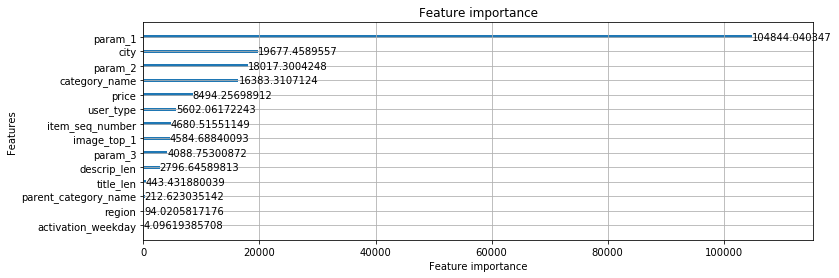

In [31]:
params['learning_rate']=0.05
lgbr=lgb.LGBMRegressor(**params)
get_lgb_params(params,cvparams,tran_table)
feat_imp=modelfit(lgbr,X_train,y_train,X_val,y_val,cat_vars,cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=30)

In [69]:
params['n_estimators']=135

# 3 Final model

In [70]:
params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'learning_rate': 0.05,
 'max_bin': 168,
 'max_depth': 29,
 'min_child_samples': 30,
 'min_child_weight': 5,
 'min_split_gain': 1,
 'n_estimators': 135,
 'n_jobs': -1,
 'num_leaves': 100,
 'objective': 'regression',
 'random_state': 9,
 'reg_alpha': 0,
 'reg_lambda': 0,
 'subsample': 0.9,
 'subsample_freq': 1}

In [71]:
lgbr_opt=lgb.LGBMRegressor(**params)

In [72]:
lgbr_opt.fit(train_X,train_y,feature_name=list(train_X.columns),categorical_feature=cat_vars)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
       learning_rate=0.05, max_bin=168, max_depth=29, min_child_samples=30,
       min_child_weight=5, min_split_gain=1, n_estimators=135, n_jobs=-1,
       num_leaves=100, objective='regression', random_state=9, reg_alpha=0,
       reg_lambda=0, silent=True, subsample=0.9, subsample_for_bin=200000,
       subsample_freq=1)

In [73]:
pred_test=lgbr_opt.predict(test_X)

In [75]:
pred_test[pred_test > 1] = 1
pred_test[pred_test < 0] = 0
sub_df = pd.DataFrame({"item_id": test_id})
sub_df["deal_probability"] = pred_test
sub_df.to_csv(data_dirs['pred_result'], index=False)

In [78]:
sub_df.head()

,item_id,deal_probability
0,6544e41a8817,0.076582
1,65b9484d670f,0.222244
2,8bab230b2ecd,0.197155
3,8e348601fefc,0.070294
4,8bd2fe400b89,0.252548
